In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import networkx as nx
import matplotlib.pyplot as plt
from scipy import stats
import warnings
from pyvinecopulib import Bicop, BicopFamily

In [6]:
tickers = {
    "BTC": "BTC-USD",
    "ETH": "ETH-USD",
    "NIFTY50": "^NSEI",
    "DXY": "UUP",
    "TNX": "^TNX"
}

df = yf.download(list(tickers.values()), start="2014-12-01", end="2024-12-31")["Close"]
df.columns = list(tickers.keys())
returns = np.log(df).diff().dropna()

C:\Users\susha\AppData\Local\Temp\ipykernel_145620\3222566806.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(list(tickers.values()), start="2014-12-01", end="2024-12-31")["Close"]
[*********************100%***********************]  5 of 5 completed


In [7]:
returns

,BTC,ETH,NIFTY50,DXY,TNX
Date,,,,,
2017-11-10,-0.076400,-0.069790,-0.000815,0.001241,0.029171
2017-11-14,0.011559,0.063948,-0.006946,-0.003758,-0.007948
2017-11-15,0.097529,-0.012740,-0.000410,-0.006752,-0.019509
2017-11-16,0.073272,-0.007325,0.001230,0.009512,0.011073
2017-11-17,-0.020886,0.004432,-0.002872,0.006718,-0.002969
...,...,...,...,...,...
2024-12-18,-0.059179,-0.071437,0.011508,-0.005652,0.024553
2024-12-19,-0.025826,-0.057106,0.001960,-0.010266,0.016770
2024-12-20,0.002714,0.015856,-0.004906,-0.015322,-0.010117


In [8]:
#probability integrity transform
def pseudo_obs(series):
    r = stats.rankdata(series, method="average")
    return r / (len(series) + 1.0)

U = returns.apply(pseudo_obs, axis=0)

In [10]:
U

,BTC,ETH,NIFTY50,DXY,TNX
Date,,,,,
2017-11-10,0.029295,0.060966,0.391924,0.508314,0.902613
2017-11-14,0.666667,0.930325,0.046714,0.262074,0.369755
2017-11-15,0.983373,0.342835,0.422803,0.162312,0.182898
2017-11-16,0.961203,0.407759,0.630245,0.868567,0.699921
2017-11-17,0.212985,0.558987,0.224861,0.758511,0.464766
...,...,...,...,...,...
2024-12-18,0.057799,0.057799,0.992082,0.186065,0.863025
2024-12-19,0.172605,0.091053,0.692795,0.084719,0.784640
2024-12-20,0.536025,0.682502,0.107680,0.037213,0.325416


In [5]:
def fit_bb7_hedge_prob(u1, u2, alpha=0.05, mc_N=20000):
    """
    u1, u2: numpy arrays of pseudo-observations in (0,1)
    Returns: hedge_prob = P(U1 > 1-alpha | U2 < alpha),
             joint_C = C(1-alpha, alpha),
             fam = fitted family name
    """
    import warnings
    from pyvinecopulib import Bicop

    data = np.column_stack([u1, u2]).astype(float)
    data = np.clip(data, 1e-8, 1-1e-8)

    try:
        bicop = Bicop.from_family("bb7")
        bicop.fit(data)
    except Exception as e:
        warnings.warn(f"BB7 fit failed, falling back to automatic selection: {e}")
        bicop = Bicop.from_data(data)
        try:
            bicop.select(data)
        except Exception:
            pass

    # Evaluate C(1-alpha, alpha)
    u_query = np.array([[1.0 - alpha, alpha]], dtype=float)
    try:
        C_1a_a = float(bicop.cdf(u_query, N=mc_N)[0])
    except Exception as e:
        warnings.warn(f"bicop.cdf failed, using empirical fallback for C(1-alpha,alpha): {e}")
        # empirical joint freq: P(U1 > 1-alpha and U2 < alpha) = count / T
        # but we need C(1-alpha, alpha) = P(U1 <= 1-alpha, U2 <= alpha)
        # so compute it directly:
        C_1a_a = ((u1 <= (1-alpha)) & (u2 <= alpha)).sum() / len(u1)

    # compute hedge prob: (alpha - C(1-alpha, alpha)) / alpha
    hedge_p = (alpha - C_1a_a) / alpha
    hedge_p = float(np.clip(hedge_p, 0.0, 1.0))

    fam = bicop.family.name if hasattr(bicop.family, 'name') else str(bicop.family)
    return hedge_p, C_1a_a, fam


In [6]:
assets = U.columns.tolist()
n = len(assets)
H = pd.DataFrame(np.zeros((n, n)), index=assets, columns=assets)  # H.loc[i,j] = P(i hedges j) = P(U_i>1-a | U_j<a)
Cmat = pd.DataFrame(np.zeros((n, n)), index=assets, columns=assets)  # store joint C(1-a,a) or empirical joint freq
family_mat = pd.DataFrame("", index=assets, columns=assets)

for i_idx, i in enumerate(assets):
    for j_idx, j in enumerate(assets):
        if i == j:
            continue
        u_i = U.iloc[:, i_idx].to_numpy()
        u_j = U.iloc[:, j_idx].to_numpy()

        p_hedge, C_1a_a, fam = fit_bb7_hedge_prob(u_i, u_j)
        if p_hedge is None:
            # fallback empirical on PITs
            p_emp, joint_emp = empirical_hedge_prob_from_pits(u_i, u_j, alpha=alpha)
            H.iloc[i_idx, j_idx] = p_emp
            Cmat.iloc[i_idx, j_idx] = joint_emp if joint_emp is not None else 0.0
            family_mat.iloc[i_idx, j_idx] = "empirical"
        else:
            H.iloc[i_idx, j_idx] = p_hedge
            Cmat.iloc[i_idx, j_idx] = C_1a_a
            family_mat.iloc[i_idx, j_idx] = fam

print("\nHedging probability matrix H (P(i > 1-alpha | j < alpha)):\n")
print(H.round(3))
print("\nFitted families (or 'empirical' fallback):\n")
print(family_mat)

C:\Users\susha\AppData\Local\Temp\ipykernel_141064\3114118719.py:18: UserWarning: BB7 fit failed, falling back to automatic selection: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_141064\3114118719.py:30: UserWarning: bicop.cdf failed, using empirical fallback for C(1-alpha,alpha): cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: pyvinecopulib.Bicop, n


Hedging probability matrix H (P(i > 1-alpha | j < alpha)):

           BTC    ETH  NIFTY50    DXY    TNX
BTC      0.000  0.017    0.097  0.065  0.113
ETH      0.002  0.000    0.097  0.081  0.081
NIFTY50  0.097  0.097    0.000  0.223  0.049
DXY      0.049  0.017    0.160  0.000  0.128
TNX      0.033  0.065    0.033  0.049  0.000

Fitted families (or 'empirical' fallback):

             BTC      ETH  NIFTY50      DXY      TNX
BTC                  tawn  student      joe      joe
ETH         tawn           student   gumbel  student
NIFTY50  student  student               bb7  student
DXY          joe   gumbel      bb7           student
TNX          joe  student  student  student         


In [7]:
G = nx.DiGraph()
G.add_nodes_from(assets)
for i in assets:
    for j in assets:
        if i == j:
            continue
        w = H.loc[i, j]
        if w >= 0.01:
            G.add_edge(j, i, weight=float(w))


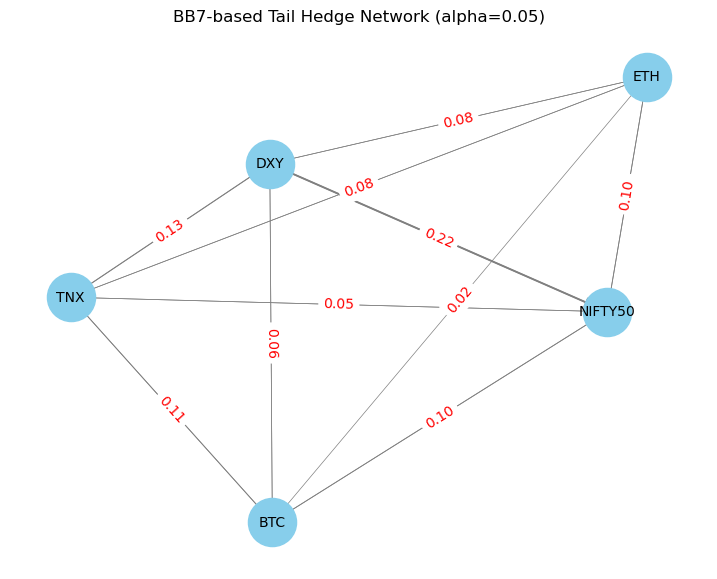

In [11]:
plt.figure(figsize=(9,7))
pos = nx.spring_layout(G, seed=2)
weights = [d['weight'] for (u,v,d) in G.edges(data=True)]
nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=1200)
nx.draw_networkx_labels(G, pos, font_size=10)
nx.draw_networkx_edges(G, pos, edge_color='gray',
                       arrowsize=16,
                       width=[max(0.5, 6*w) for w in weights])
edge_labels = {(u,v): f"{d['weight']:.2f}" for u,v,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
plt.title(f"BB7-based Tail Hedge Network (alpha=0.05)")
plt.axis('off')
plt.show()